<a href="https://colab.research.google.com/github/rraghavkaushik/Image-to-Image-Translation/blob/main/Image_to_Image_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# from tensorflow import keras
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization, Conv2DTranspose
from keras.utils import plot_model
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256, 256, 6)    │              0 │ input_layer[0][0],     │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 256)  │         24,832 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 256)  │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 128, 128, 256)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 512)  │      2,097,664 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 512)  │          2,048 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 128, 128, 512)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 1)    │          8,193 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 1)    │              0 │ conv2d_4[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,133,761 (8.14 MB)

 Trainable params: 2,132,225 (8.13 MB)

 Non-trainable params: 1,536 (6.00 KB)

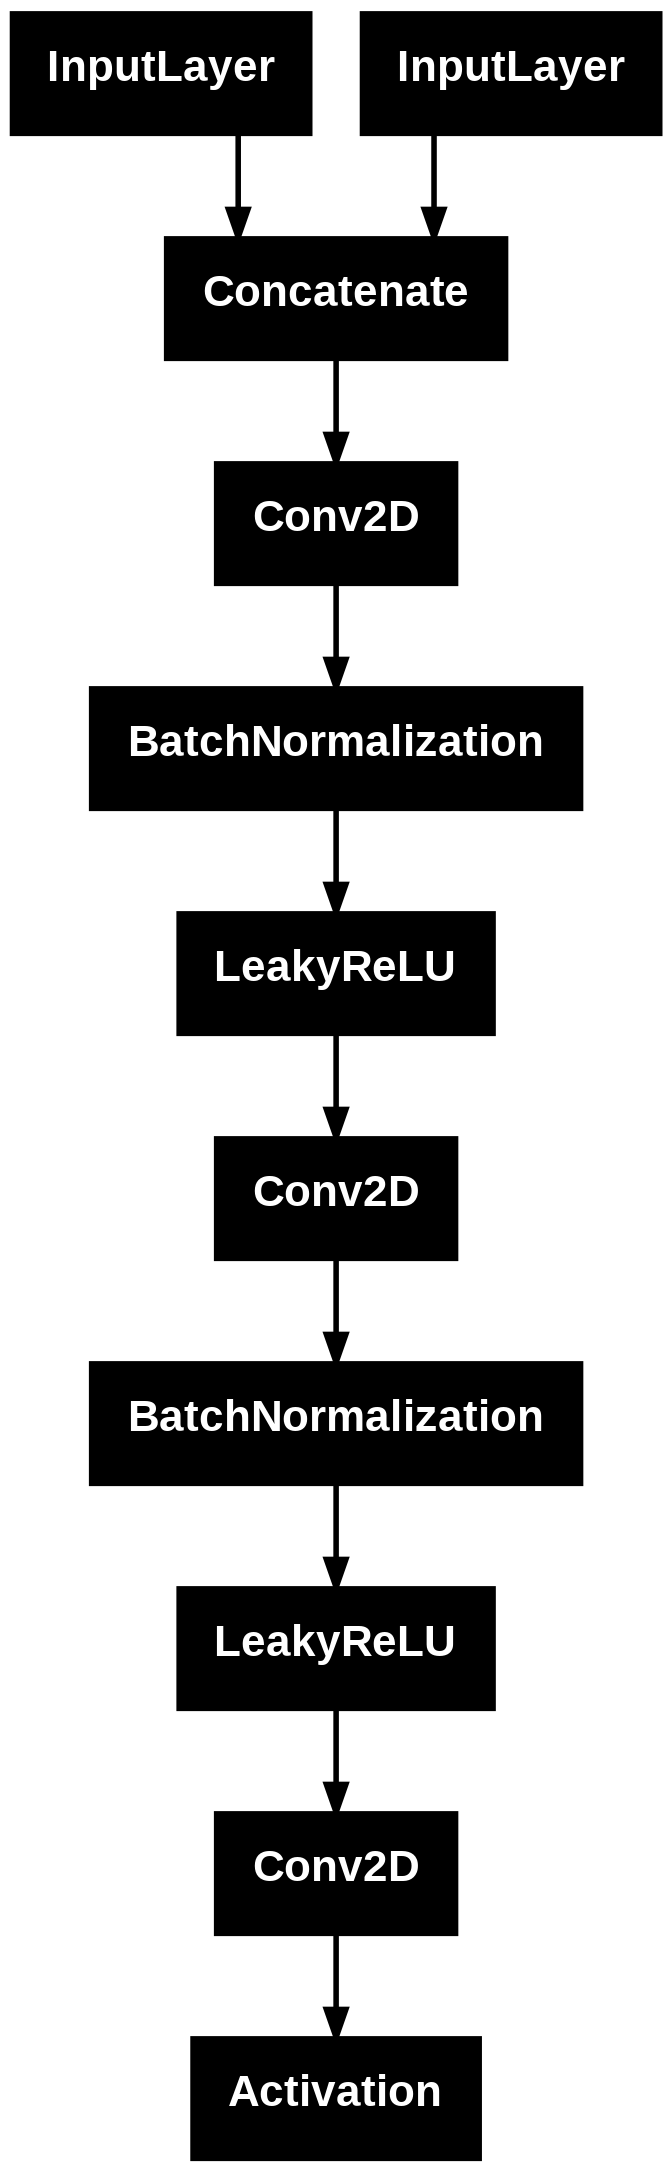

In [ ]:
def discriminator_defn(img_size):
  wt = RandomNormal(stddev = 0.02)
  src_img = Input(shape = img_size)
  target_img = Input(shape = img_size)
  ''' concatenating channel wise'''
  conc_img = Concatenate()([src_img, target_img])

  ''' Discriminator architechture described in the paper :
    C64-C128-C256-C512
    After the last layer, a convolution is applied to map to
    a 1-dimensional output, followed by a Sigmoid function.
    As an exception to the above notation, BatchNorm is not
    applied to the first C64 layer. All ReLUs are leaky, with
    slope 0.2.'''


  l = Conv2D(64, (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = wt)(conc_img)
  l = LeakyReLU(alpha = 0.2)(l)

  l = Conv2D(128, (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = wt)(conc_img)
  l = BatchNormalization()(l)
  l = LeakyReLU(alpha = 0.2)(l)

  l = Conv2D(256, (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = wt)(conc_img)
  l = BatchNormalization()(l)
  l = LeakyReLU(alpha = 0.2)(l)

  l = Conv2D(512, (4, 4), padding = 'same', kernel_initializer = wt)(l)
  l = BatchNormalization()(l)
  l = LeakyReLU(alpha = 0.2)(l)

  l = Conv2D(1, (4, 4), padding = 'same', kernel_initializer = wt)(l)
  output = Activation('sigmoid')(l)

  model = Model(inputs = [src_img, target_img], outputs = output)
  model.summary()
  model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999), metrics = ['accuracy'])
  return model

disc_model = discriminator_defn((256, 256, 3))
# plt.imshow(disc_model)
plot_model(disc_model)

In [ ]:
''' encoder-decoder architechture as described in the paper:
    encoder:
    C64-C128-C256-C512-C512-C512-C512-C512
    decoder:
    CD512-CD512-CD512-C512-C256-C128-C64
    All ReLUs in the encoder are leaky, with slope 0.2, while
    ReLUs in the decoder are not leaky '''

def encoder(layer, n, batch_norm = True):
  wt = RandomNormal(stddev = 0.02)
  l = Conv2D(n, (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = wt)(layer)
  if batch_norm:
    l = BatchNormalization()(l, training = True)
  l = LeakyReLU(alpha = 0.02)(l)
  return l

def decoder(layer, skip, n, dropout = True):
  wt = RandomNormal(stddev = 0.02)
  l = Conv2DTranspose(n, (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = wt)(layer)
  l = BatchNormalization()(l, training = True)
  if dropout:
    l = Dropout(0.5)(l, training = True)
  l = Concatenate()([l , skip])
  l = Activation('relu')(l)
  return l

def generator(img_size):
  wt = RandomNormal(stddev = 0.02)
  src_img = Input(shape = img_size)

  l1 = encoder(src_img, 64, batch_norm = False)
  l2 = encoder(l1, 128)
  l3 = encoder(l2, 256)
  l4 = encoder(l3, 512)
  l5 = encoder(l4, 512)
  l6 = encoder(l5, 512)
  l7 = encoder(l6, 512)

  b = Conv2D(512, (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = wt)(l7)
  b = Activation('relu')(b)

  d1 = decoder(b, l7, 512)
  d2 = decoder(d1, l6, 512)
  d3 = decoder(d2, l5, 512)
  d4 = decoder(d3, l4, 512, dropout = False)
  d5 = decoder(d4, l3, 256, dropout = False)
  d6 = decoder(d5, l2, 128, dropout = False)
  d7 = decoder(d6, l1, 64, dropout = False)

  l = Conv2DTranspose(3, (4, 4), strides = (2, 2), padding = 'same', kernel_initializer = wt)(d7)
  output = Activation('tanh')(l)

  model = Model(src_img, output)
  model.summary()
  return model

gen = generator((256, 256, 3))
# plot_model(gen, to_file = 'generator.png')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 64)   │          3,136 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 128, 128, 64)   │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 128)    │        131,200 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 256)    │        524,544 │ leaky_re_lu_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 256)    │          1,024 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU) │ (None, 32, 32, 256)    │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 512)    │      2,097,664 │ leaky_re_lu_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 16, 16, 512)    │          2,048 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU) │ (None, 16, 16, 512)    │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 512)      │      4,194,816 │ leaky_re_lu_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 8, 8, 512)      │          2,048 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 8, 8, 512)      │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 4, 4, 512)      │      4,194,816 │ leaky_re_lu_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 4, 4, 512)      │          2,048 │ conv2d_10[0][0]        │
│ (BatchNormalization) 

 Total params: 54,429,315 (207.63 MB)

 Trainable params: 54,419,459 (207.59 MB)

 Non-trainable params: 9,856 (38.50 KB)

In [ ]:
def GAN(gen, disc, img_size):
  for i in disc.layers:
    if not isinstance(i, BatchNormalization):
      i.trainable = False
  disc.trainable = False
  src_img = Input(shape = img_size)
  gen_output = gen(src_img)
  disc_output = disc([src_img, gen_output])
  model = Model(src_img, [disc_output, gen_output])
  optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999)
  model.compile(loss = ['binary_crossentropy', 'mae'], optimizer = optimizer, loss_weights = [1, 100])
  return model

In [ ]:
def load_real_imgs(data, n_samples, patch_size):
  trainA, trainB = data
  i = np.random.randint(0, trainA.shape[0], n_samples)
  X1, X2 = trainA[i], trainB[i]
  y = np.ones((n_samples, patch_size, patch_size, 1))
  return [X1, X2], y

def load_fake_imgs(gen, n_samples, patch_size):
  X = gen.predict(data)
  y = np.zeros((len(X), patch_size, patch_size, 0))
  return X, y



In [ ]:
from re import X
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = load_real_imgs(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = load_fake_imgs(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

def train(disc, gen, gan, data, epochs = 100, n_batch = 1):
  n_patch = disc.output_shape[1]
  trainA, trainB = data
  batches_per_epoch = int(len(trainA)/n_batch)
  n_steps = batches_per_epoch * epochs
  for i in range(n_steps):
    [X_realA, X_realB], y_real = load_real_imgs(data, n_batch, n_patch)
    X_fakeB, y_fake = load_fake_imgs(gen, X_realA, n_patch)
    loss1 = disc.train_on_batch([X_realA, X_realB], y_real)
    loss2 = disc.train_on_batch([X_realA, X_fakeB], y_fake)
    gen_loss, _, _ = gan.train_on_batch(X_realA, [y_real, X_realB])
    print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, loss1, loss2, gen_loss))
    if (i+1) % (batches_per_epoch * 10) == 0:
		    summarize_performance(i, gen, data)

In [ ]:
def load_images(path, size=(256,512)):
    src_list, tar_list = list(), list()
    for filename in listdir(path):
        pixels = load_img(path + filename, target_size=size)
        pixels = img_to_array(pixels)
        sat_img, map_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(sat_img)
        tar_list.append(map_img)
    return [asarray(src_list), asarray(tar_list)]

path = 'maps/train/'
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)

n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(src_images[i].astype('uint8'))

for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

from pix2pix_model import define_discriminator, define_generator, define_gan, train
image_shape = src_images.shape[1:]
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

data = [src_images, tar_images]

def preprocess_data(data):
    X1, X2 = data[0], data[1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

dataset = preprocess_data(data)

from datetime import datetime
start1 = datetime.now()

train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1)

stop1 = datetime.now()
execution_time = stop1 - start1
print("Execution time is: ", execution_time)

from keras.models import load_model
from numpy.random import randint
model = load_model('saved_model_10epochs.h5')

def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    for i in range(len(images)):
        pyplot.subplot(1, 3, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(images[i])
        pyplot.title(titles[i])
    pyplot.show()

[X1, X2] = dataset
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
gen_image = model.predict(src_image)
plot_images(src_image, gen_image, tar_image)
